In [116]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

### Load images from dataset

In [140]:
train_dir = './chest_xray/train/'
test_dir = './chest_xray/test/'
val_dir = './chest_xray/val/'

img_width = 160
img_height = 160

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed = 123,
    image_size = (img_width, img_height),
    batch_size=None
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed = 123,
    image_size = (img_width, img_height),
    batch_size=None 
)
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed = 123,
    image_size = (img_width, img_height),
    batch_size=None
)
print(val_data.class_names)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']


### Resize images and load data into numpy arrays

In [141]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train_data:
    imagen = cv2.resize(feature.numpy(), (img_width, img_height))
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagen = imagen.reshape(img_width, img_height, 1)
    x_train.append(imagen)
    y_train.append(label.numpy())

for feature, label in test_data:
    imagen = cv2.resize(feature.numpy(), (img_width, img_height))
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagen = imagen.reshape(img_width, img_height, 1)
    x_test.append(imagen)
    y_test.append(label.numpy())
    
for feature, label in val_data:
    imagen = cv2.resize(feature.numpy(), (img_width, img_height))
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagen = imagen.reshape(img_width, img_height, 1)
    x_val.append(imagen)
    y_val.append(label.numpy())

X_train = np.array(x_train)
y_train = np.array(y_train)
X_val = np.array(x_val)
y_val = np.array(y_val)
X_test = np.array(x_test)
y_test = np.array(y_test)

### Data Visualization

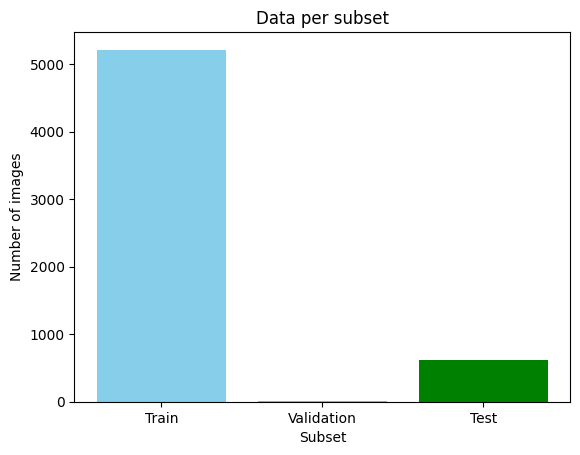

In [142]:
count = [len(y_train), len(y_val), len(y_test)]
labels = ['Train', 'Validation', 'Test']

plt.bar(labels, count, color=['skyblue', 'orange', 'green'])
plt.title('Data per subset')
plt.ylabel('Number of images')
plt.xlabel('Subset')
plt.show()

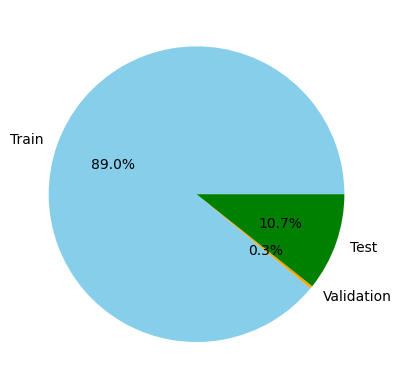

In [143]:
total = sum(count)
subset_percentages = []
for _, conjunto in enumerate(count):
    percentage = round((100 * conjunto / total), 1)
    subset_percentages.append(percentage)

plt.pie(subset_percentages, labels=labels, autopct='%.1f%%', colors=['skyblue', 'orange', 'green'])
plt.show()

#### The subsets from the dataset are highly unbalanced, the best option is merge them and split the dataset in only train and validation

In [144]:
X = np.concatenate((X_train, X_test, X_val))
y = np.concatenate((y_train, y_test, y_val))

### Overview of the number samples per class

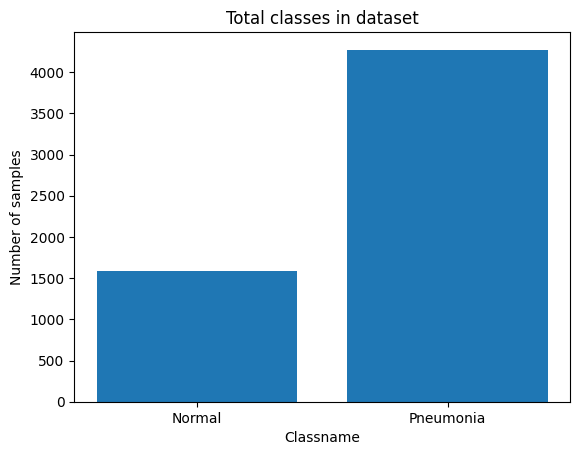

In [145]:
unique, counts = np.unique(y, return_counts=True)
labels = ['Normal', 'Pneumonia']
plt.bar(labels, counts)
plt.title('Total classes in dataset')
plt.xlabel('Classname')
plt.ylabel('Number of samples')
plt.show()

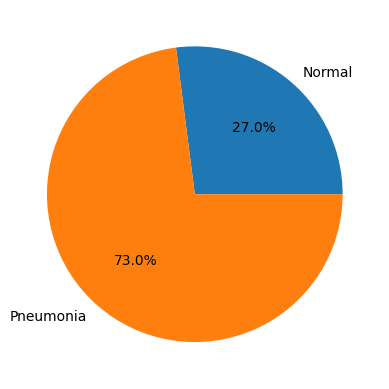

In [146]:
data = dict(zip(unique, counts))
total_data = y.size
pneumonia = ((100 * data.get(1) ) / total_data)
normal = ((100 * data.get(0)) / total_data)

plt.pie([normal, pneumonia], labels=['Normal', 'Pneumonia'], autopct='%.1f%%')
plt.show()

#### The number of samples per class is also very unbalanced, this will cause the model prone to overfit.

Spliting data in train and validation - 80% for traning and 20% for validation

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}")

#You can also split the data manually:
#X_train = X[:4685]
#X_val = X[1171:]

#y_train = y[:4685]
#y_val = y[1171:]


X_train: (4684, 160, 160, 1), X_val: (1172, 160, 160, 1)
y_train: (4684,), y_val: (1172,)


### Rescale layer will help to reduce time and improve quality of the learning process, the data augmentation layers will help to reduce overfitting

In [148]:
#Reescalar las imagenes
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])
#Capa de aumento de datos
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(factor=0.2),

])

### CNN Architecture 

In [149]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation, 
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2), padding='same'), 

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2), padding='same'), 
        
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2), padding='same'), 
        
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Model traning

In [150]:
history = model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs = 20,
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7242 - loss: 0.5738 - val_accuracy: 0.8549 - val_loss: 0.3060
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8655 - loss: 0.3124 - val_accuracy: 0.8157 - val_loss: 0.3930
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8692 - loss: 0.3049 - val_accuracy: 0.8874 - val_loss: 0.2465
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8951 - loss: 0.2561 - val_accuracy: 0.8942 - val_loss: 0.2456
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8942 - loss: 0.2532 - val_accuracy: 0.8993 - val_loss: 0.2305
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8938 - loss: 0.2578 - val_accuracy: 0.9113 - val_loss: 0.2126
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9055 - loss: 0.2416 - val_accuracy: 0.9044 - val_loss: 0.2336
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9153 - loss: 0.2046 - 

### Evaluating the model

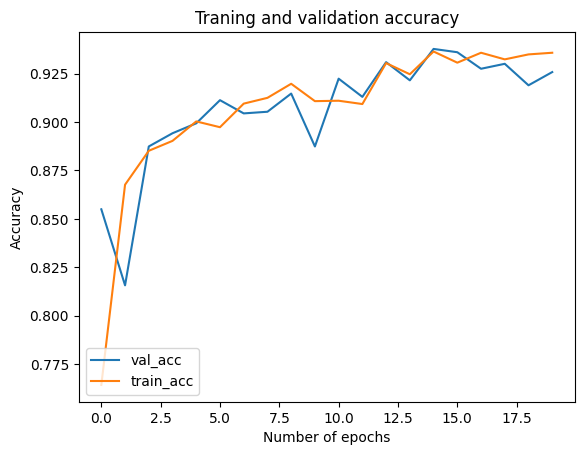

In [151]:
plt.figure()
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.title('Traning and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(loc='lower left')
plt.show()

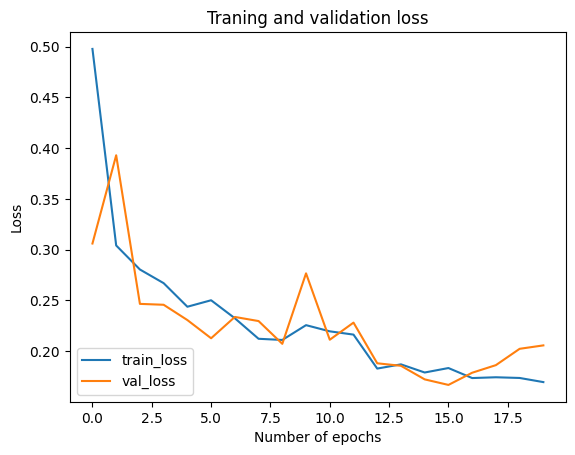

In [152]:
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Traning and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.show()